In [1]:
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from pprint import pprint
print(os.getcwd())
image_dir = "/work/growth_chamber/images"
mask_dir = "/work/growth_chamber/output/output"

/


In [2]:
import glob
# Define the naming scheme
naming_scheme = os.path.join(image_dir, "topview_*.jpg")
# Get all file names that match the naming scheme
image_filenames = glob.glob(naming_scheme)

print(len(image_filenames))       


856


In [3]:
# Input/output options
args = WorkflowInputs(
    images=image_filenames,    
    names='test',
    result="topview_results",
    outdir=".",
    writeimg=False,
    # debug="plot",
    sample_label="plant"
    )
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Set plotting size (default = 100)
pcv.params.dpi = 200
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

In [4]:
for file in tqdm(image_filenames):
    base_name = file.split('/')[-1].split('.')[0]
    img, path, filename = pcv.readimage(filename=file)
    mask_filename = os.path.join(mask_dir, base_name)
    # print(len(glob.glob(f"{mask_filename}_*.jpg")))
    for mask_file in glob.glob(f"{mask_filename}_*.jpg"):
        # print(f"Processing {file} with mask {mask_file}")
        mask, mask_path, mask_filename = pcv.readimage(filename=mask_file)
        plant_id = mask_filename.split('/')[-1].split('.')[0].split('_')[-1]
        # print(f"{base_name}_plant{plant_id}")
        shape_img = pcv.analyze.size(
            img=img, 
            labeled_mask=mask,
            label= f"{base_name}_{plant_id}",
            n_labels=1)
        # colo_img = pcv.analyze.color(rgb_img=img,
        #     labeled_mask=mask,
        #     n_labels=1,
        #     label= f"{base_name}_{plant_id}", 
        #     colorspaces="HSV"
        #     )
pcv.outputs.save_results(filename='/work/growth_chamber/pcv_output.json')

100%|█████████████████| 856/856 [1:09:02<00:00,  4.84s/it]


In [5]:
import pandas as pd 
import re 
rows = []
for i in pcv.outputs.observations.keys():
    match = re.search(r"topview_(\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2})", i)
    time_stamp = match.group(1)
    plant_id = i.split('_')[-2]
    # print(time_stamp,plant_id)
    obs_data = {k: v["value"] for k, v in pcv.outputs.observations[i].items()}
    # Convert to datetime
    rows.append({
        "timestamp" : pd.to_datetime(time_stamp, format="%Y-%m-%d_%H_%M_%S"),
        "plant_id": plant_id,
        **obs_data 
    })

df = pd.DataFrame(rows)
pprint(df.head())


df.to_csv('/work/growth_chamber/pcv_data_frame.csv')                                                    

            timestamp plant_id  in_bounds    area  convex_hull_area  solidity  \
0 2024-08-06 11:15:01        8       True  1405.0          182741.5  0.007688   
1 2024-08-06 11:15:01        9       True  1799.0          239785.5  0.007503   
2 2024-08-06 11:15:01        3       True  2134.0          286871.5  0.007439   
3 2024-08-06 11:15:01       13       True  1859.0          147937.0  0.012566   
4 2024-08-06 11:15:01        1      False  2122.0          277285.5  0.007653   

       perimeter  width  height  longest_path  \
0   85556.673603    528     480    548.639226   
1  114459.787256    655     600    627.034289   
2  145846.558862    704     656    671.607772   
3  101149.177242    512     456    527.784994   
4  162764.797185    672     568    640.415490   

                             center_of_mass  convex_hull_vertices  \
0  (1857.2868327402134, 1321.9039145907473)                    17   
1  (1877.5869927737633, 1823.0155642023346)                    23   
2    (950.9

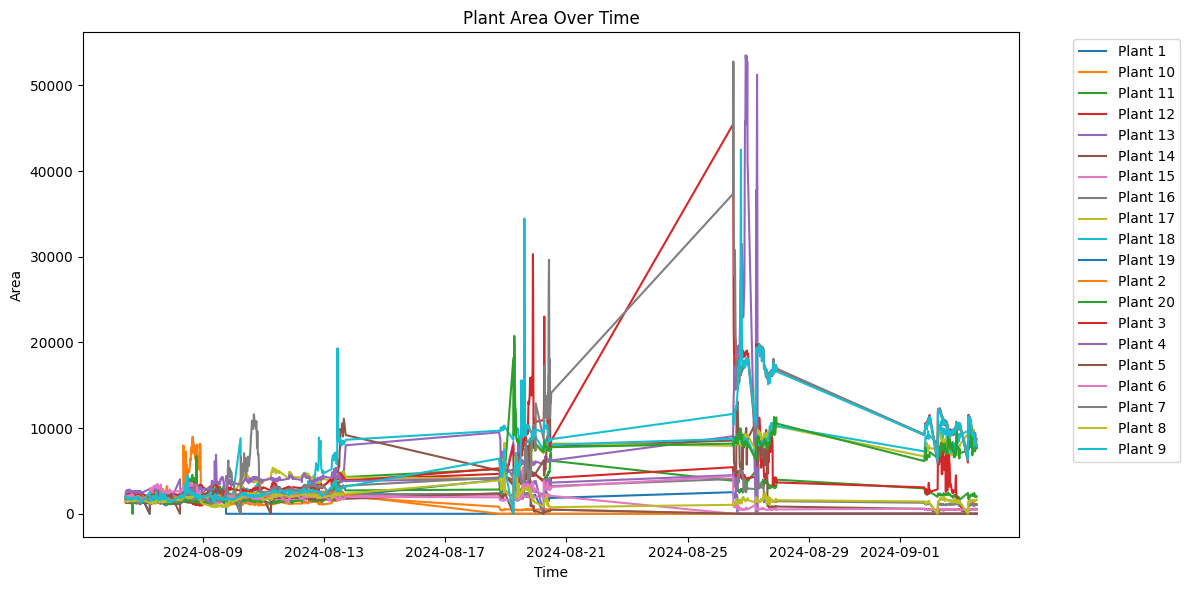

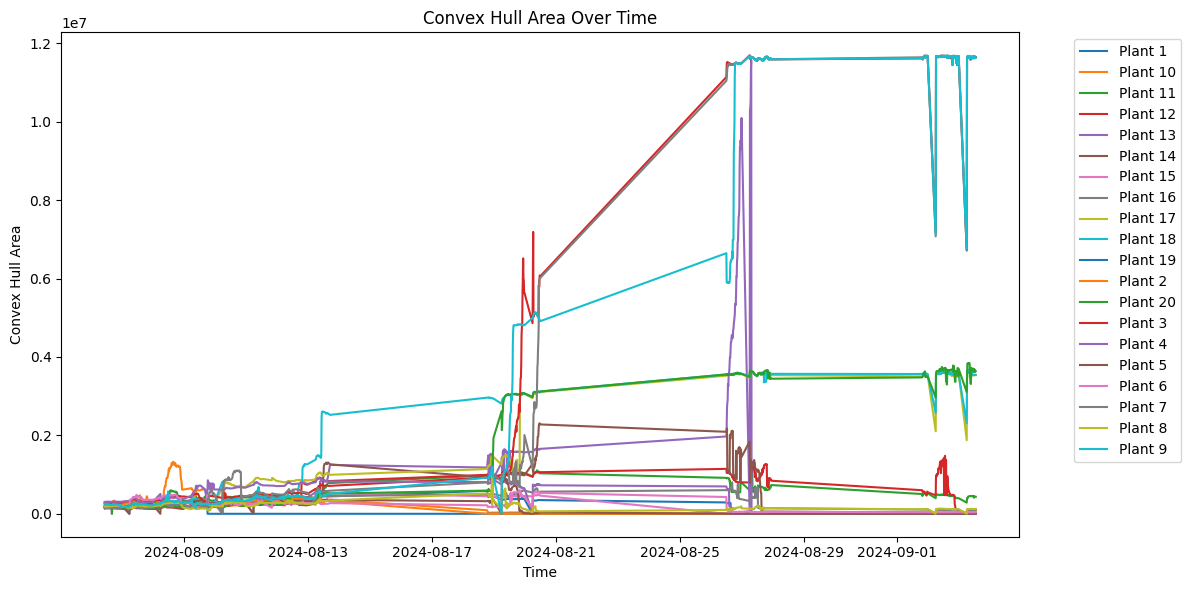

In [6]:
import matplotlib.pyplot as plt

# Make sure timestamp column is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by plant and time (just in case)
df = df.sort_values(["plant_id", "timestamp"])

# Plot area over time for each plant
plt.figure(figsize=(12,6))
for plant_id, group in df.groupby("plant_id"):
    plt.plot(group["timestamp"], group["area"], label=f"Plant {plant_id}")
plt.xlabel("Time")
plt.ylabel("Area")
plt.title("Plant Area Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot convex_hull_area over time for each plant
plt.figure(figsize=(12,6))
for plant_id, group in df.groupby("plant_id"):
    plt.plot(group["timestamp"], group["convex_hull_area"], label=f"Plant {plant_id}")
plt.xlabel("Time")
plt.ylabel("Convex Hull Area")
plt.title("Convex Hull Area Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


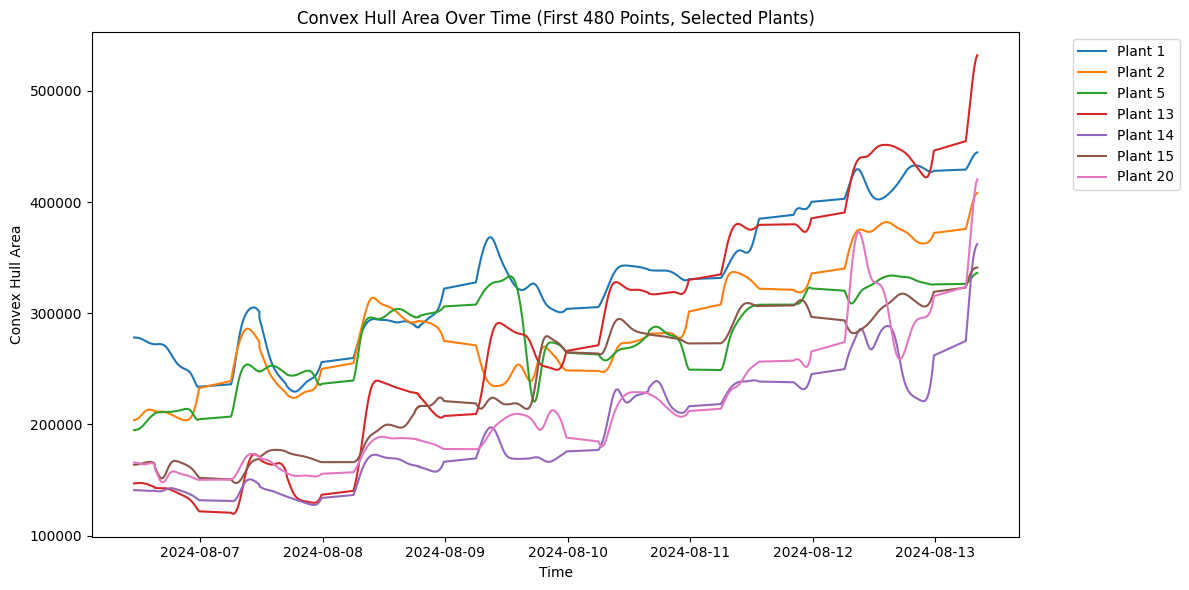

In [43]:
from scipy.ndimage import gaussian_filter1d
# Exclude unwanted plants
# exclude_plants = { 4, 6, 7, 10,12, 17,18, 19}
exclude_plants = {3,4,6, 7,8,9,10,11,12,16,17, 18, 19}
df["plant_id"] = df["plant_id"].astype(int)
df_filtered = df[~df["plant_id"].isin(exclude_plants)]

# Keep only the first 480 time points overall
df_filtered = (
    df_filtered.sort_values("timestamp")
    .groupby("plant_id")
    .head(480)
)



# Plot convex_hull_area over time
plt.figure(figsize=(12,6))
for plant_id, group in df_filtered.groupby("plant_id"):
    smoothed = gaussian_filter1d(group["convex_hull_area"].values, sigma=4) 
    plt.plot(group["timestamp"], smoothed, label=f"Plant {plant_id}")

plt.xlabel("Time")
plt.ylabel("Convex Hull Area")
plt.title("Convex Hull Area Over Time (First 480 Points, Selected Plants)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()